In [49]:
import pandas as pd
import deepchem as dc
import numpy as np
from tqdm import tqdm
import torch
import data_utils as HIVLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

## Load Datasets

In [2]:
df = HIVLoader.load_main_data()
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,False
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,False
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,False
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,False
4,O=S(=O)(O)CCS(=O)(=O)O,CI,False


## Data Preparation

In [3]:
train_ds, test_ds = HIVLoader.scaffold_split(df)
print(f'total: {len(train_ds):5d}, active: {sum(train_ds.y):4d}, inactive: {sum(train_ds.y == False):5d}')
print(f'total: {len(test_ds):5d}, active: {sum(test_ds.y):4d}, inactive: {sum(test_ds.y == False):5d}')

[11:06:59] WARNING: not removing hydrogen atom without neighbors
[11:06:59] WARNING: not removing hydrogen atom without neighbors


total: 32901, active: 1219, inactive: 31682
total:  8226, active:  211, inactive:  8015


In [5]:
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
transformer = dc.trans.FeaturizationTransformer(featurizer=featurizer)

train_feat = train_ds.transform(transformer)
test_feat = test_ds.transform(transformer)


[11:08:59] WARNING: not removing hydrogen atom without neighbors
[11:08:59] WARNING: not removing hydrogen atom without neighbors


## Modelling

In [72]:
from typing import Any

def print_dict(dictionary, sep=', '):
  result = [f'{k}: {v:.4f}' for k, v in dictionary.items()]
  print(sep.join(result))

def train_model(create_model, train_data, test_data, transformer, save_dir, epoch=10, batch_size=64):
  model = create_model()
  metrics = [dc.metrics.Metric(metric) for metric in [roc_auc_score, f1_score, accuracy_score]]
  best_metric = {
    'f1_score': float('-inf'),
    'roc_auc_score': float('-inf')
  }
  
  for i in range(epoch):
    losses = []
    for X, y, w, _ in tqdm(train_data.iterbatches(batch_size), total=np.ceil(len(train_feat)/batch_size)):
      loss = model.fit_on_batch(X, y, w)
      losses.append(loss)
    
    result_metrics = model.evaluate(test_data, metrics, transformers=[transformer])
    result_metrics['train_loss'] = np.mean(np.array(losses))
    result_metrics['epoch'] = i
    
    for metric, value in best_metric.items():
      if result_metrics[metric] > value:
        best_metric[metric] = result_metrics[metric]
        model.save_checkpoint(1, os.path.join(save_dir, f'best_{metric}'))
    
    print_dict(result_metrics)
  
  best_model = {}
  for metric, score in best_metric.items():
    _model = create_model()
    _model.restore(os.path.join(save_dir, f'best_{metric}', 'checkpoint1.pt'))
    best_model[metric] = (_model, score)
    
  return best_model

def evaluate_model(model, dataset):
  metrics = [dc.metrics.Metric(metric) for metric in [roc_auc_score, f1_score, accuracy_score, recall_score]]
  result_metrics = model.evaluate(dataset, metrics, transformers=[transformer])
  
  logits = model.predict(dataset, transformers=[transformer])
  preds = np.argmax(logits, axis=1)

  cm = confusion_matrix(test_feat.y, preds, normalize='true')
  disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm)
  
  cm = confusion_matrix(test_feat.y, preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  
  return result_metrics, (disp, disp_norm)

### Graph Convolution Model

In [73]:
gcn_model = lambda: dc.models.GCNModel(mode='classification', n_tasks=1, learning_rate=0.001, device=torch.device('cuda'))
best_gcn_model = train_model(gcn_model, train_feat, test_feat, transformer, save_dir='checkpoints/GCM')

100%|██████████| 515/515.0 [00:19<00:00, 26.60it/s]


roc_auc_score: 0.7533, f1_score: 0.1063, accuracy_score: 0.6994, train_loss: 0.7852, epoch: 0.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.70it/s]


roc_auc_score: 0.7566, f1_score: 0.2469, accuracy_score: 0.9258, train_loss: 0.7327, epoch: 1.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.61it/s]


roc_auc_score: 0.6926, f1_score: 0.1054, accuracy_score: 0.7958, train_loss: 0.7108, epoch: 2.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.65it/s]


roc_auc_score: 0.7619, f1_score: 0.1309, accuracy_score: 0.7933, train_loss: 0.6855, epoch: 3.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.80it/s]


roc_auc_score: 0.7593, f1_score: 0.2490, accuracy_score: 0.9282, train_loss: 0.6520, epoch: 4.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.81it/s]


roc_auc_score: 0.7717, f1_score: 0.1178, accuracy_score: 0.7360, train_loss: 0.6416, epoch: 5.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.43it/s]


roc_auc_score: 0.7818, f1_score: 0.1229, accuracy_score: 0.7518, train_loss: 0.6183, epoch: 6.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.40it/s]


roc_auc_score: 0.7668, f1_score: 0.1411, accuracy_score: 0.8164, train_loss: 0.6053, epoch: 7.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.77it/s]


roc_auc_score: 0.7609, f1_score: 0.0959, accuracy_score: 0.6652, train_loss: 0.5819, epoch: 8.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.48it/s]


roc_auc_score: 0.7669, f1_score: 0.2215, accuracy_score: 0.9120, train_loss: 0.5754, epoch: 9.0000


Model evaluation with f1_score:0.2490
roc_auc_score: 0.7593
f1_score: 0.2490
accuracy_score: 0.9282
recall_score: 0.4645


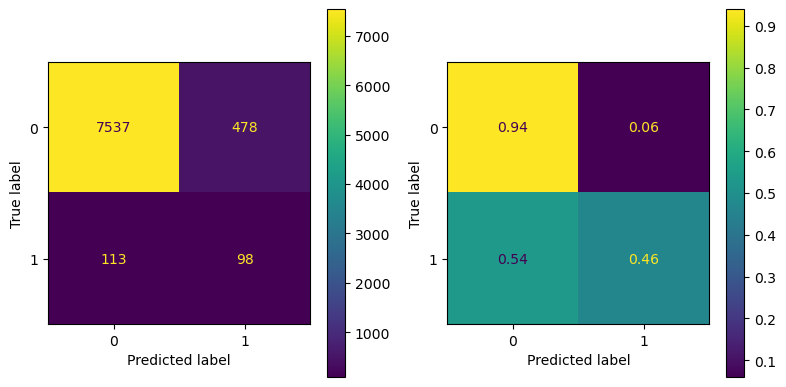

Model evaluation with roc_auc_score:0.7818
roc_auc_score: 0.7818
f1_score: 0.1229
accuracy_score: 0.7518
recall_score: 0.6777


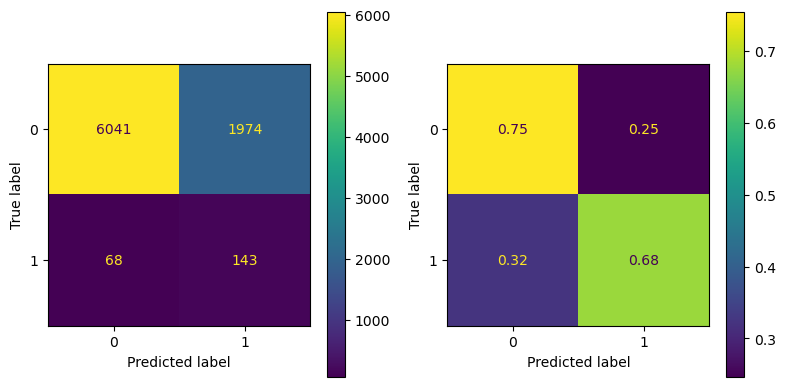

In [74]:
for i, (metric, (model, score)) in enumerate(best_gcn_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()

### AttentiveFP

In [75]:
afp_model = lambda: dc.models.AttentiveFPModel(mode='classification', n_tasks=1, learning_rate=0.001, device=torch.device('cuda'))
best_afp_model = train_model(gcn_model, train_feat, test_feat, transformer, save_dir='checkpoints/AtentiveFP')

  0%|          | 0/515.0 [00:00<?, ?it/s]

100%|██████████| 515/515.0 [00:19<00:00, 26.62it/s]


roc_auc_score: 0.7427, f1_score: 0.1356, accuracy_score: 0.8124, train_loss: 0.7847, epoch: 0.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.65it/s]


roc_auc_score: 0.7447, f1_score: 0.1489, accuracy_score: 0.8401, train_loss: 0.7471, epoch: 1.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.63it/s]


roc_auc_score: 0.7715, f1_score: 0.1591, accuracy_score: 0.8535, train_loss: 0.7207, epoch: 2.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.67it/s]


roc_auc_score: 0.7600, f1_score: 0.1392, accuracy_score: 0.8226, train_loss: 0.6932, epoch: 3.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.50it/s]


roc_auc_score: 0.7907, f1_score: 0.1567, accuracy_score: 0.8220, train_loss: 0.6659, epoch: 4.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.55it/s]


roc_auc_score: 0.7584, f1_score: 0.2381, accuracy_score: 0.9222, train_loss: 0.6485, epoch: 5.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.62it/s]


roc_auc_score: 0.7951, f1_score: 0.1506, accuracy_score: 0.8080, train_loss: 0.6398, epoch: 6.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.81it/s]


roc_auc_score: 0.7464, f1_score: 0.1064, accuracy_score: 0.7366, train_loss: 0.6216, epoch: 7.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.45it/s]


roc_auc_score: 0.7832, f1_score: 0.1137, accuracy_score: 0.7157, train_loss: 0.6053, epoch: 8.0000


100%|██████████| 515/515.0 [00:19<00:00, 26.87it/s]


roc_auc_score: 0.7973, f1_score: 0.1883, accuracy_score: 0.8648, train_loss: 0.5922, epoch: 9.0000


Model evaluation with f1_score:0.2381
roc_auc_score: 0.7584
f1_score: 0.2381
accuracy_score: 0.9222
recall_score: 0.4739


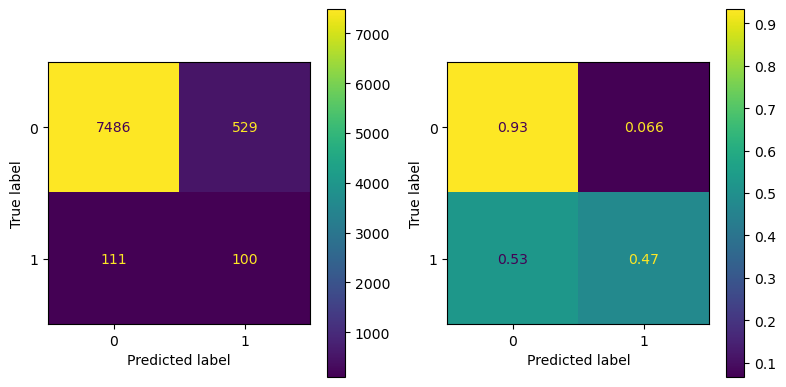

Model evaluation with roc_auc_score:0.7973
roc_auc_score: 0.7973
f1_score: 0.1883
accuracy_score: 0.8648
recall_score: 0.6114


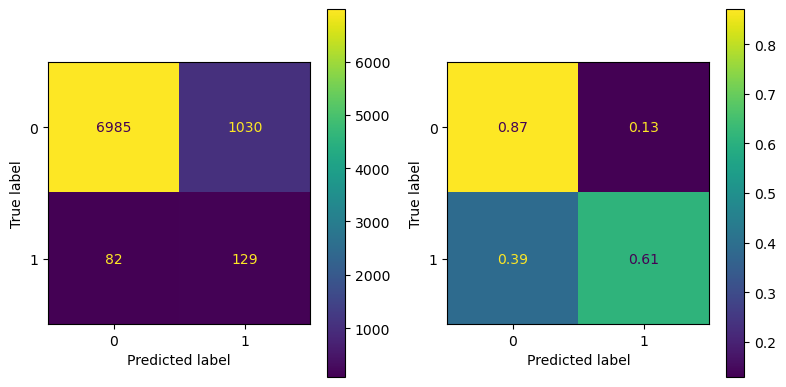

In [76]:
for i, (metric, (model, score)) in enumerate(best_afp_model.items()):
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  metrics, cms = evaluate_model(model, test_feat)
  print(f'Model evaluation with {metric}:{score:.4f}')
  print_dict(metrics, '\n')
  
  for ax, cm in zip(axs, cms): cm.plot(ax=ax)
  plt.tight_layout() 
  plt.show()